<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/challenges/challenge-one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

In [139]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os

random_state = 0

In [140]:
# Load the dataset using Pandas
# We know a priori the features name so we use them
# We are lucky because our Category is already a numeric value so no transformation are needed
data = pd.read_csv('data_banknote_authentication.txt', header = None, names = ['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Category'])
df = pd.DataFrame(data)
df.head()

,Variance,Skewness,Curtosis,Entropy,Category
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


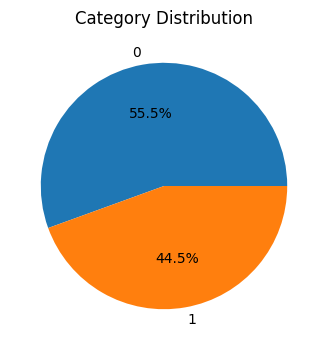

In [141]:
# Visualize the category distribution with a pie chart
category_counts = df['Category'].value_counts()
category_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(4, 4))
plt.title('Category Distribution', fontsize=12)
plt.ylabel('')
plt.show()

In [142]:
# Having pretty good balanced data is good.
# Shuffling the dataset is needed since it is ordered by category.
df = df.sample(frac=1).reset_index(drop=True)

In [143]:
from scipy.stats import shapiro

# Test the gaussianity of the columns just for ourself.

for col in df.columns: 
    if col != 'Category':
        p, stat = shapiro(df[col])
        print(f"{col}:")
        if p > 0.05:
            print(f"  Data seems to follow gaussian distribution [p-value {p}].")
        else:
            print(f"  Data does not seem to follow gaussian distribution [p-value {p}].")

# Standardize
for col in df.columns: 
    if col != 'Category':
        df[col] = (df[col] - df[col].mean()) / df[col].std()

Variance:
  Data seems to follow gaussian distribution [p-value 0.9819974938117768].
Skewness:
  Data seems to follow gaussian distribution [p-value 0.9746343038389303].
Curtosis:
  Data seems to follow gaussian distribution [p-value 0.927092532564125].
Entropy:
  Data seems to follow gaussian distribution [p-value 0.9148761718506765].


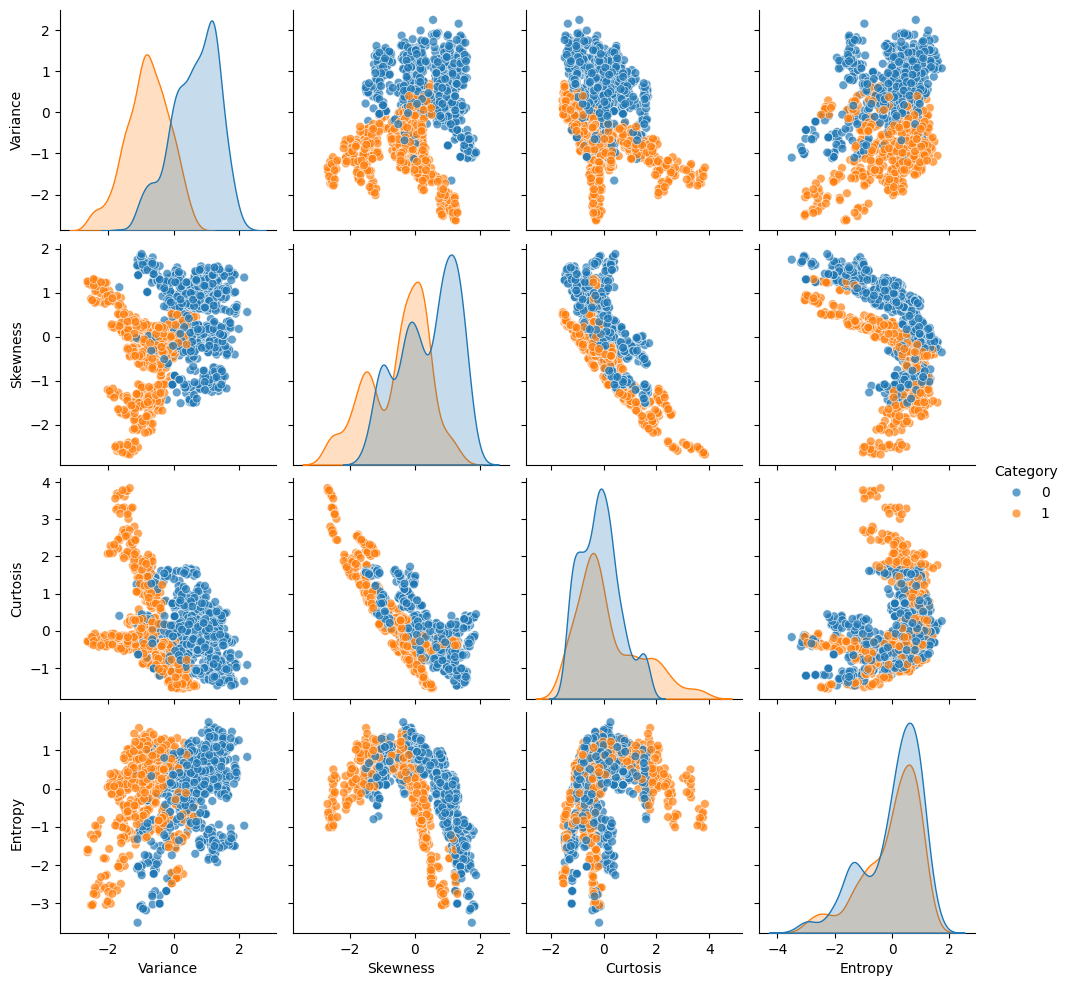

In [144]:
sns.pairplot(df, hue = 'Category', plot_kws={'alpha': 0.7, 's': 40})
plt.show()

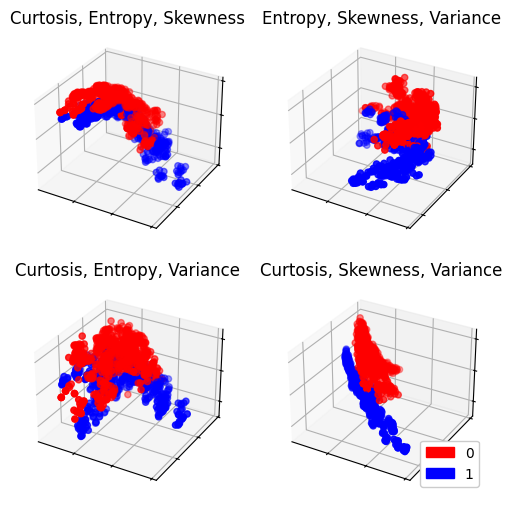

In [145]:
triplets = []
headers = list(df.columns.values)
headers.remove('Category')
triplets = []
for i in range (4):
    for j in range (4):
        for z in range (4):
            if i != j and i != z and j != z:
                to_append = [headers[i], headers[j], headers[z]]
                to_append.sort()
                to_append = tuple(to_append)
                triplets.append(to_append)
triplets = set(triplets)
triplets = [list(trip) for trip in triplets]
df_proof = df[[c for c in df.columns if c in triplets[0]]]

def tridimensional_plot(df, triplets, colors, legend_patches):
    fig = plt.figure(figsize = (6, 6))
    for i, triplet in enumerate(triplets):
        axs = fig.add_subplot(2, 2, i + 1, projection='3d')
        axs.scatter(df[triplet[0]],df[triplet[1]], df[triplet[2]], c = colors, depthshade=True)
        #fig.colorbar(img, location = 'bottom', label = 'State', aspect = 50)
        axs.set_title(f'{triplet[0]}, {triplet[1]}, {triplet[2]}')
        axs.set_yticklabels([])
        axs.set_xticklabels([])  
        axs.set_zticklabels([])
    # Create a legend with a color box
    patches = [mpatches.Patch(color=col, label=lab) for col, lab in legend_patches]
    plt.legend(handles=patches, loc='lower right', framealpha=1, frameon=True)
    plt.show()

colors = ['b' if s == 1 else 'r' for s in df['Category']]
tridimensional_plot(df, triplets, colors, [('r', 0), ('b', 1)])

### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

In [146]:
def plot_2d(x, y, color, name):
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.scatter(x, y, c=color)
    ax.set_title(name)

    plt.show()

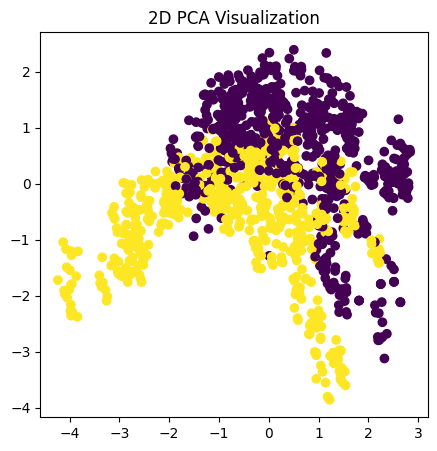

In [147]:
from sklearn.decomposition import PCA

nc = 2 # number of components considered

data = np.array(df.drop(columns=['Category']))
pca_2d = PCA(n_components=nc)
data_pca_2d = pca_2d.fit_transform(data)
plot_2d(data_pca_2d[:, 0], data_pca_2d[:, 1], df['Category'], "2D PCA Visualization")

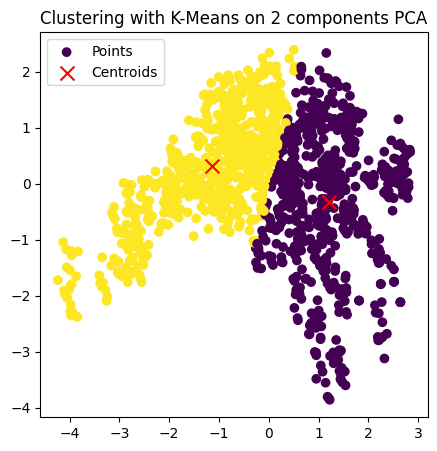

0.5583090379008746


In [148]:
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from scipy.stats import mode

def kmeans_accuracy(predictions, ground_truth):
    c = 0
    for p, g in zip(predictions, ground_truth):
        c = c + (int(p) == int(g))
    return max(1 - c/len(predictions), c/len(predictions)) # since kmeans does not really classify something as 1 o 0 

kmeans_2d = KMeans(n_clusters=2, random_state=random_state)
kmeans_2d.fit(data_pca_2d)
labels_2d = kmeans_2d.labels_
centroids_2d = kmeans_2d.cluster_centers_
fig, axs = plt.subplots(figsize = (5, 5))
axs.scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], c=labels_2d, label='Points')
axs.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='x', s=100, label='Centroids')
axs.legend() 
plt.title("Clustering with K-Means on 2 components PCA")
plt.show()

accuracy_2d = kmeans_accuracy(labels_2d, df['Category'])
print(accuracy_2d)

In [149]:
def plot_3d(x, y, z, color, name):
    fig = plt.figure(figsize = (5, 5))

    axs = fig.add_subplot(111, projection='3d')
    axs.scatter(x, y, z, c = color, depthshade=True)
    axs.set_title(name)

    plt.show()

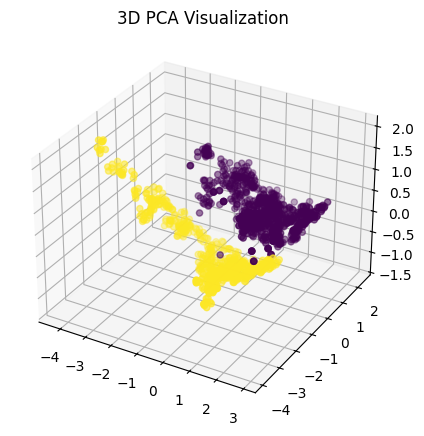

In [150]:
nc = 3 # number of components considered

data = np.array(df)
pca_3d = PCA(n_components=nc, random_state=random_state)
data_pca_3d = pca_3d.fit_transform(data)
plot_3d(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2] , df['Category'], "3D PCA Visualization")

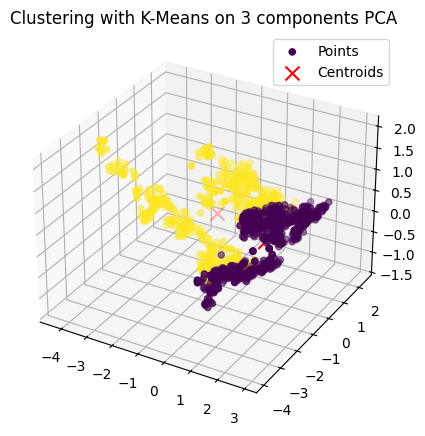

0.5677842565597667


In [151]:
kmeans_3d = KMeans(n_clusters=2, random_state=random_state)
kmeans_3d.fit(data_pca_3d)
labels_3d = kmeans_3d.labels_
centroids_3d = kmeans_3d.cluster_centers_
fig = plt.figure(figsize = (5, 5))
axs = fig.add_subplot(111, projection='3d')
axs.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2],c=labels_3d, label='Points')
axs.scatter(centroids_3d[:, 0], centroids_3d[:, 1], c='red', marker='x', s=100, label='Centroids')
axs.legend()
plt.title("Clustering with K-Means on 3 components PCA")
plt.show()

accuracy_3d = kmeans_accuracy(labels_3d, df['Category'])
print(accuracy_3d)

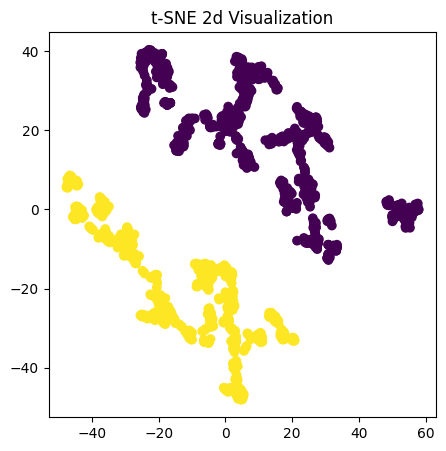

In [152]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, learning_rate='auto', perplexity=30, random_state=random_state).fit_transform(data)
plot_2d(tsne_2d[:, 0], tsne_2d[:, 1], df['Category'], 't-SNE 2d Visualization')

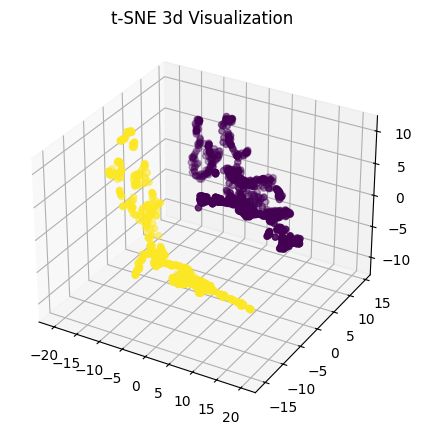

In [153]:
tsne_3d = TSNE(n_components=3, learning_rate='auto', perplexity=30, random_state=random_state).fit_transform(data)
plot_3d(tsne_3d[:, 0], tsne_3d[:, 1], tsne_3d[:, 2],df['Category'], 't-SNE 3d Visualization')

4


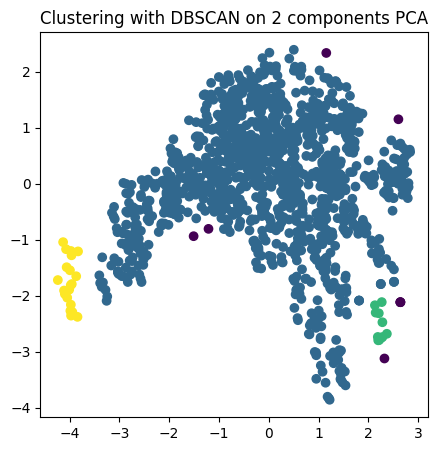

In [154]:
from sklearn.cluster import DBSCAN

dbscan_2d = DBSCAN(eps=0.3, min_samples=4)
dbscan_2d.fit(data_pca_2d)
labels_2d = dbscan_2d.labels_
print(len(set(labels_2d))) 
plot_2d(data_pca_2d[:, 0], data_pca_2d[:, 1], labels_2d,"Clustering with DBSCAN on 2 components PCA")

9


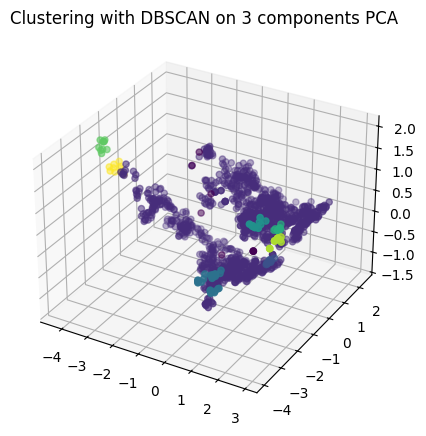

In [155]:
dbscan_3d = DBSCAN(eps=0.4, min_samples=6)
dbscan_3d.fit(data_pca_3d)
labels_3d = dbscan_3d.labels_
print(len(set(labels_3d))) # this is the number of clusters found
plot_3d(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2],labels_3d,"Clustering with DBSCAN on 3 components PCA")

3


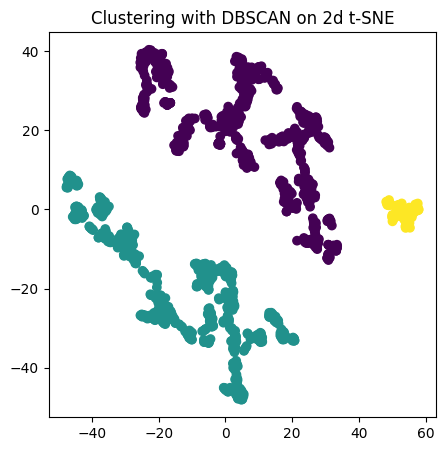

In [156]:
dbscan_2d = DBSCAN(eps=10, min_samples=3)
dbscan_2d.fit(tsne_2d)
labels_2d = dbscan_2d.labels_
print(len(set(labels_2d))) 
plot_2d(tsne_2d[:, 0], tsne_2d[:, 1], labels_2d,"Clustering with DBSCAN on 2d t-SNE")

3


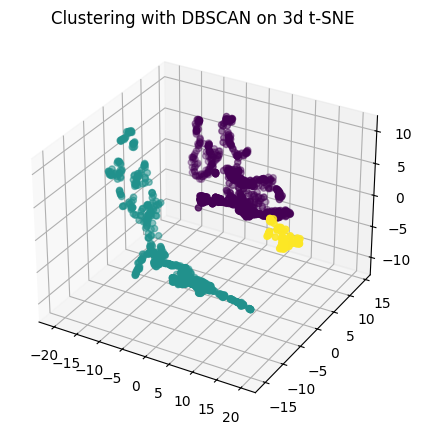

In [157]:
dbscan_3d = DBSCAN(eps=5, min_samples=6)
dbscan_3d.fit(tsne_3d)
labels_3d = dbscan_3d.labels_
print(len(set(labels_3d))) # this is the number of clusters found
plot_3d(tsne_3d[:, 0], tsne_3d[:, 1], tsne_3d[:, 2], labels_3d, "Clustering with DBSCAN on 3d t-SNE")

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN. 

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed. 

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     


In [158]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = np.array(df.drop(columns=['Category']))
Y = np.array(df['Category'])
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=372, random_state=random_state) # to have 372 element in the test set


### Logistic Model

In [ ]:
from sklearn.linear_model import LogisticRegression

model_n = LogisticRegression(None, random_state=random_state)
model_l1 = LogisticRegression('l1', C = 10, solver="liblinear",  random_state=random_state)
model_l2 = LogisticRegression('l2', C = 10, random_state=random_state)
model_en = LogisticRegression('elasticnet', C = 5, solver="saga", l1_ratio=0.5,  random_state=random_state)
model_n.fit(X_train, Y_train)
model_l1.fit(X_train, Y_train)
model_l2.fit(X_train, Y_train) 
model_en.fit(X_train, Y_train)

c:\Users\Frekko\Documents\Università\INTRODUZIONE AL ML\Intro_to_ML_24-25\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=20, l1_ratio=0.5, penalty='elasticnet', random_state=0,
                   solver='saga')

In [160]:
def model_stats_and_visualize(model, x_test, y_test, name):
    print(name)
    y_pred = model.predict(x_test)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    pca_2d = PCA(n_components=2)
    data_pca_2d = pca_2d.fit_transform(x_test)

    fig, ax = plt.subplots(figsize=(5, 5))

    color = []
    for y_t, y_p in zip(y_test, y_pred):
        if y_t != y_p:
            if y_p == 0:
                color.append((1, 0.4, 0))
            else:
                color.append((0.85, 0, 0))
        elif y_t == y_p:
            if y_p == 0:
                color.append((0.4, 1, 0))
            else:
                color.append((0, 0.85, 0))
    ax.scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], c=color)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.title(name)
    plt.show()

Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       222
           1       0.97      0.99      0.98       150

    accuracy                           0.99       372
   macro avg       0.98      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



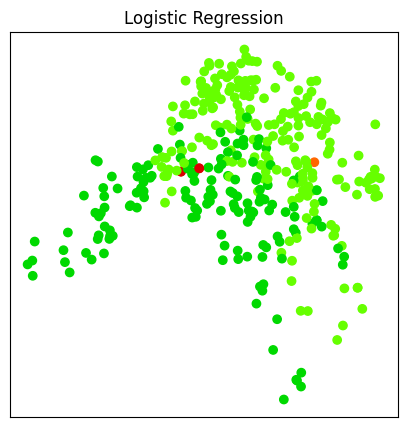

In [161]:
model_stats_and_visualize(model_n, x_test, y_test, "Logistic Regression")

Logistic Regression L1

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       222
           1       0.97      0.99      0.98       150

    accuracy                           0.99       372
   macro avg       0.98      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



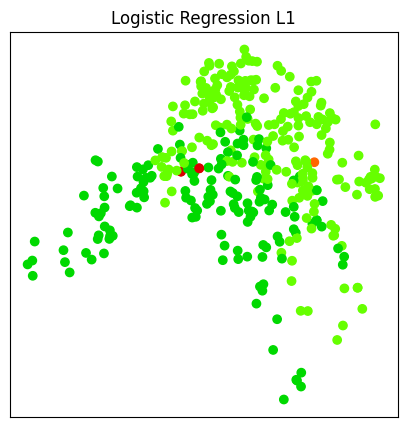

In [162]:
model_stats_and_visualize(model_l1, x_test, y_test, "Logistic Regression L1")

Logistic Regression L2

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       222
           1       0.97      1.00      0.99       150

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



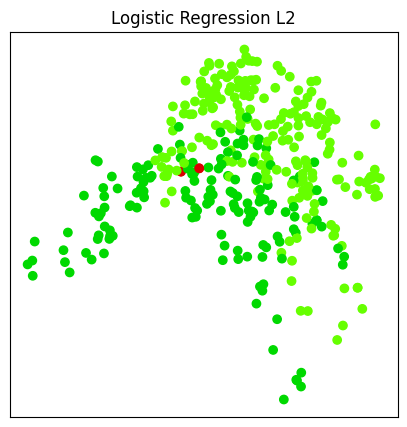

In [163]:
model_stats_and_visualize(model_l2, x_test, y_test, "Logistic Regression L2")

Logistic Regression ElasticNet

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       222
           1       0.97      0.99      0.98       150

    accuracy                           0.99       372
   macro avg       0.98      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



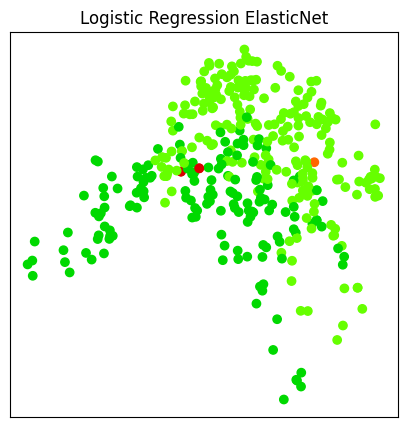

In [164]:
model_stats_and_visualize(model_en, x_test, y_test, "Logistic Regression ElasticNet")

### Decision Tree

In [165]:
from sklearn import tree

Decision Tree Classifier

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       222
           1       0.99      0.99      0.99       150

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



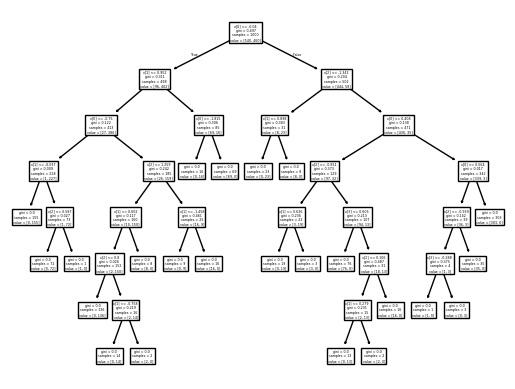

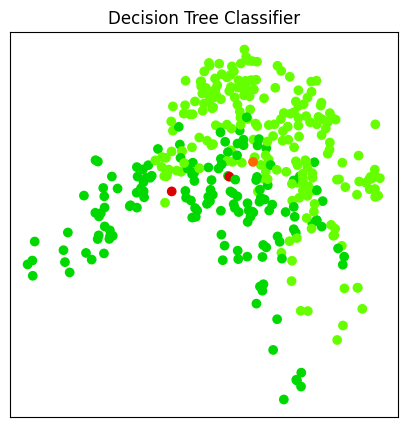

In [166]:
model_t = tree.DecisionTreeClassifier()
model_t.fit(X_train, Y_train)
tree.plot_tree(model_t)
model_stats_and_visualize(model_t, x_test, y_test, "Decision Tree Classifier")

We see almost perfect results. No cross validation is needed.

### Naive Bayes

In [167]:
from sklearn import naive_bayes

Naive Bayes

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89       222
           1       0.85      0.81      0.83       150

    accuracy                           0.86       372
   macro avg       0.86      0.85      0.86       372
weighted avg       0.86      0.86      0.86       372



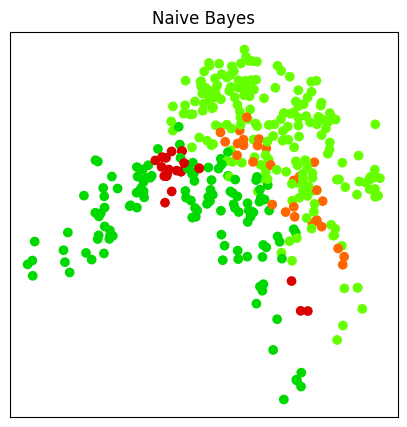

In [168]:
model_nb = naive_bayes.GaussianNB()
model_nb.fit(X_train, Y_train)
model_stats_and_visualize(model_nb, x_test, y_test, "Naive Bayes")

This actually is the first model where problems occour. We can now try some cross validation to tune the hyperparameters.

### K Neighbors

In [169]:
from sklearn import neighbors

K Neighbors

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00       150

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



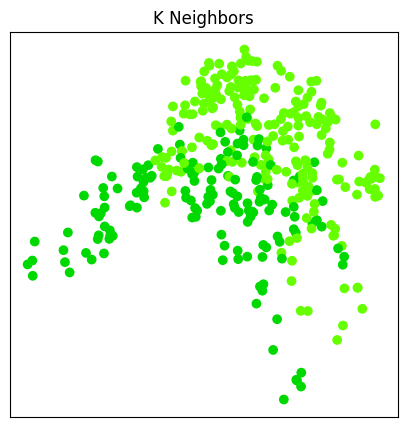

In [170]:
model_kn = neighbors.KNeighborsClassifier()
model_kn.fit(X_train, Y_train)
model_stats_and_visualize(model_kn, x_test, y_test, "K Neighbors")

We can see perfect results. No cross validation is needed.

### Neural Network

This is done with the personal purpouse of trying something else

In [171]:
# Implemented a little neural network just because
import keras
from keras import layers
from sklearn.model_selection import train_test_split

def one_hot_encode(Y):
    encoded_Y = np.zeros(shape=(len(Y), 2))
    for i, y in enumerate (Y):
        if y == 0:
            encoded_Y[i][0] = 1
            encoded_Y[i][1] = 0
        else:
            encoded_Y[i][0] = 0
            encoded_Y[i][1] = 1
    return encoded_Y

Y_n = one_hot_encode(Y)

X_train, x_test, Y_train, y_test = train_test_split(X, Y_n, test_size=0.2)

model = keras.Sequential(
    [
        layers.Dense(8, activation="relu", name="layer1"),
        layers.Dense(16, activation="relu", name="layer2"),
        layers.Dense(32, activation="relu", name="layer3"),
        layers.Dense(16, activation="relu", name="layer4"),
        layers.Dense(8, activation="relu", name="layer5"),
        layers.Dense(2, activation="softmax", name="output")
    ]
)

model.compile(optimizer = "rmsprop", loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose = 0)

model.evaluate(x_test, y_test, return_dict=True, verbose = 0)

{'accuracy': 0.9599999785423279, 'loss': 0.10430431365966797}